# Setup

In [4]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *


sim_folder = 'L025N752/DMONLY/SigmaConstant00/no_gravity'


@chex.dataclass
class Primordial():

    # Momenta of the Cl maps
    Cl_qs = jnp.geomspace(0.01, 100, 50)

    # Select index closest to desired q value
    q_select = 3.15
    Cl_qi = jnp.abs(Cl_qs - q_select).argmin()
    # print(f"closest q value to {q_select} in log spaced array is {Cl_qs[Cl_qi]}")

    # Temperature perturbations, in micro Kelvin
    uK = 1e-6*Params.K    # micro Kelvin
    Nside = 8
    Npix = hp.nside2npix(Nside)

    T_CNB_z4 = Params.T_CNB*(1+4)


def healpix_side_by_side(map_left, map_right, dict_left, dict_right, args):

    fig = plt.figure(figsize=(12, 4.4))
    fig.tight_layout()

    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    # Remove all ticks, labels and frames, to only show mollview plot.
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_xaxis().set_ticks([])
    ax1.get_yaxis().set_ticks([])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.get_xaxis().set_ticks([])
    ax2.get_yaxis().set_ticks([])

    hp.newvisufunc.projview(
        map_left,
        **dict_left,
        **args.healpy_dict)

    hp.newvisufunc.projview(
        map_right,
        **dict_right,
        **args.healpy_dict)
    
    plt.show(); plt.close()


def momentum_distribution(y_arr, nbins, args):
    """
    Plot a momentum histogram with logarithmically spaced bins.
    """

    # Generating logarithmically spaced bins
    log_bins = np.logspace(
            np.log10(np.min(y_arr)), np.log10(np.max(y_arr)), nbins)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Plot simulation distances
    ax.hist(
        y_arr, bins=log_bins, 
        color="blue", label="CNB simulation", alpha=0.8)
    
    ax.set_xscale("log")
    ax.set_title("Momentum distribution at z=4 (Log Bins)")
    ax.set_xlabel(r"$p_\mathrm{back}/T_\mathrm{CNB,0}$")
    ax.set_ylabel("Nr. of neutrinos")
    ax.legend(loc="upper left")

    plt.show(); plt.close()


def cartesian_to_healpix(Nside_map, xyz_pos_in, obs_pos_in):

    # Center on observer position.
    xyz_pos = xyz_pos_in - obs_pos_in
    x, y, z = xyz_pos[:,0], xyz_pos[:,1], xyz_pos[:,2]

    # Convert x,y,z to angles.
    proj_xy_plane_dis = np.sqrt(x**2 + y**2)

    thetas = np.arctan2(z, proj_xy_plane_dis)
    phis = np.arctan2(y, x)

    # To galactic latitude and longitude (in degrees) for healpy.
    hp_glon, hp_glat = np.rad2deg(phis), np.rad2deg(thetas)

    # Convert angles to pixel indices using ang2pix.
    pixel_indices = hp.ang2pix(
            Nside_map, hp_glon, hp_glat, lonlat=True
    )

    # Create a Healpix map and increment the corresponding pixels
    healpix_map = np.zeros(hp.nside2npix(Nside_map))
    np.add.at(healpix_map, pixel_indices, 1)

    return pixel_indices, healpix_map


def find_closest_m_nu(sim_folder, m_nu_target_eV):

    m_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
    m_idx = jnp.abs(m_range - m_nu_target_eV).argmin()
    m_val = m_range[m_idx]

    return m_idx, m_val

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# No Gravity

## Skymaps of temp. fluctuations

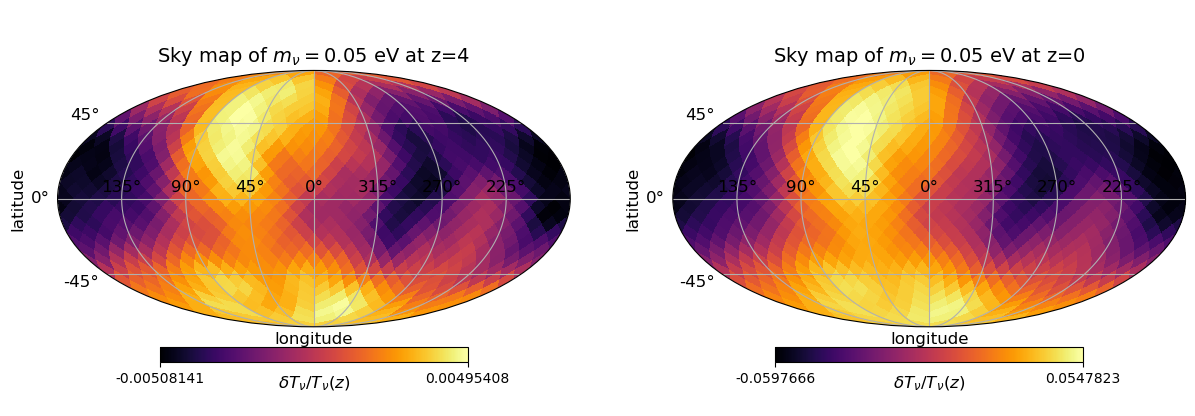

In [5]:
# Load temperature fluctuations.
Delta_folder = f"Data/Deltas"
Deltas_z0 = jnp.load(f"{Delta_folder}/Delta_arr_Nside{Primordial.Nside}_Cl_q{Primordial.Cl_qi}_z0.npy")*Primordial.uK
Deltas_z4 = jnp.load(f"{Delta_folder}/Delta_arr_Nside{Primordial.Nside}_Cl_q{Primordial.Cl_qi}_z4.npy")*Primordial.uK

# Healpy maps and plot parameters
map_left = Deltas_z4/Primordial.T_CNB_z4
map_right = Deltas_z0/Params.T_CNB

dict_left = dict(
    title=r'Sky map of $m_\nu=0.05$ eV at z=4', 
    unit=r'$\delta T_\nu / T_\nu (z)$',
    cmap='inferno',
    sub=121)

dict_right = dict(
    title=r'Sky map of $m_\nu=0.05$ eV at z=0', 
    unit=r'$\delta T_\nu / T_\nu (z)$',
    cmap='inferno',
    sub=122)

healpix_side_by_side(
    map_left, map_right, dict_left, dict_right, Params)

### Values from Tully & Zhang (2021) Fig. 5 left

In [3]:
TZ_val_left = -176166*Primordial.uK
TZ_val_right = 157773*Primordial.uK
ic(TZ_val_left/Params.T_CNB)
ic(TZ_val_right/Params.T_CNB)
# Our temp. perturbation values are close to theirs, when using q~3.15
# (they use their "q average")

ic| TZ_val_left/Params.T_CNB: Array(-0.09055727, dtype=float64, weak_type=True)
ic| TZ_val_right/Params.T_CNB: Array(0.08110244, dtype=float64, weak_type=True)


Array(0.08110244, dtype=float64, weak_type=True)

## Testcase: No-gravity CNB simulation

/home/fabian/anaconda3/envs/dev/lib/python3.12/site-packages/healpy/newvisufunc.py:407: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn(
/home/fabian/anaconda3/envs/dev/lib/python3.12/site-packages/healpy/newvisufunc.py:411: UserWarning: 
 *** New plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.1, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn("\n *** New plot properies: " + str(plot_properties) + " ***")


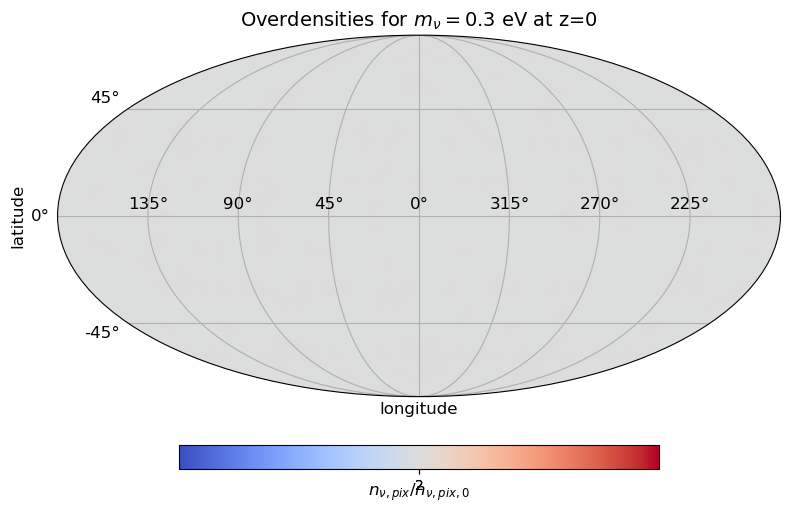

In [4]:
# Starting with no-gravity sim, load vectors and densities
nu_vectors = jnp.load(f'{sim_folder}/neutrino_vectors_numerical_no_gravity_all_sky.npy')
# (768000, 2, 6)
nu_densities = jnp.load(f'{sim_folder}/number_densities_numerical_no_gravity_all_sky.npy')
# (768, 100)

# note: nu_densities for no-gravity might have been computed before I changed g_nu to 1 in the shared Params class, and hence in the number_density function, so the map shows 2, not 1. 
etas = nu_densities / (Params.N0/Primordial.Npix/(1/Params.cm**3))

# note: this is no-gravity, so all pixels are the same, and sum to 1, i.e. N0
hp.newvisufunc.projview(
    etas[:,-1], 
    title=r'Overdensities for $m_\nu=0.3$ eV at z=0', 
    unit=r'$n_{\nu, pix} / n_{\nu, pix, 0}$',
    cmap='coolwarm',
    override_plot_properties={"cbar_pad": 0.1},
    **Params.healpy_dict)
plt.show(); plt.close()

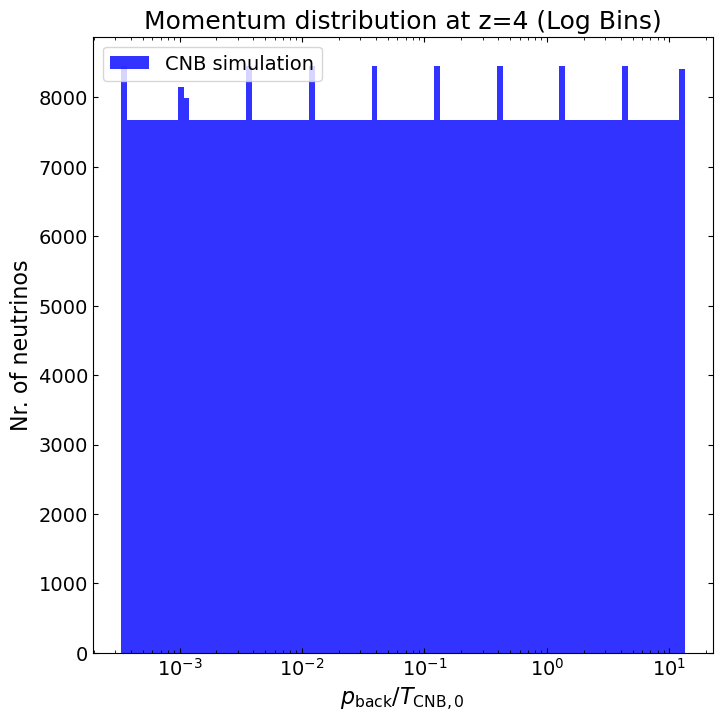

/home/fabian/anaconda3/envs/dev/lib/python3.12/site-packages/healpy/newvisufunc.py:407: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn(
/home/fabian/anaconda3/envs/dev/lib/python3.12/site-packages/healpy/newvisufunc.py:411: UserWarning: 
 *** New plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.1, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn("\n *** New plot properies: " + str(plot_properties) + " ***")


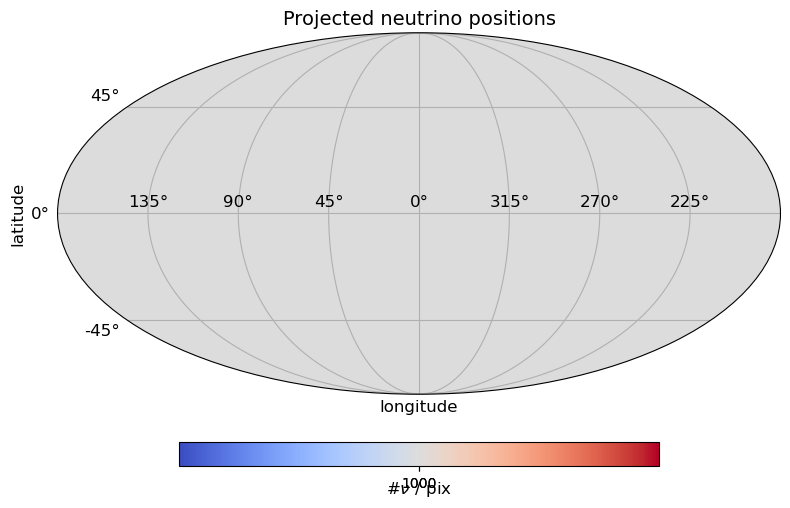

In [11]:
# Neutrino masses
nu_masses = jnp.array([0.01, 0.05, 0.1, 0.3])*Params.eV

# Convert to momenta
v_arr = nu_vectors[...,3:]
p_arr, y_arr = Physics.velocities_to_momenta(v_arr, nu_masses, Params())
# (4, 768000, 2)

m_idx = 0
z4_y_arr = y_arr[m_idx,:,-1]
momentum_distribution(z4_y_arr, 100, Params())

x_arr = nu_vectors[:,-1,:3]
pix_indices, hp_map = cartesian_to_healpix(
    Nside_map=8, xyz_pos_in=x_arr, obs_pos_in=jnp.array([8.5,0,0]))

jnp.save(f"Data/pix_indices.npy", pix_indices)

hp.newvisufunc.projview(
    hp_map, 
    title=r'Projected neutrino positions', 
    unit=r'#$\nu$ / pix',
    cmap='coolwarm',
    override_plot_properties={"cbar_pad": 0.1},
    **Params.healpy_dict)
plt.show(); plt.close()

## Match Boundaries

ic| idx: Array(47, dtype=int64), val: Array(0.05026429, dtype=float64)
ic| Delta_matrix[Primordial.Cl_qi,:].min(): Array(-0.00509952, dtype=float64)
ic| Delta_matrix[Primordial.Cl_qi,:].max(): Array(0.00497174, dtype=float64)
ic| jnp.sum(map_left): Array(767.53984235, dtype=float64)
/home/fabian/anaconda3/envs/dev/lib/python3.12/site-packages/healpy/newvisufunc.py:407: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn(
/home/fabian/anaconda3/envs/dev/lib/python3.12/site-packages/healpy/newvisufunc.py:411: UserWarning: 
 *** New plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.1, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn("\n *** New plot properies: " + str(plot_properties) + " ***")


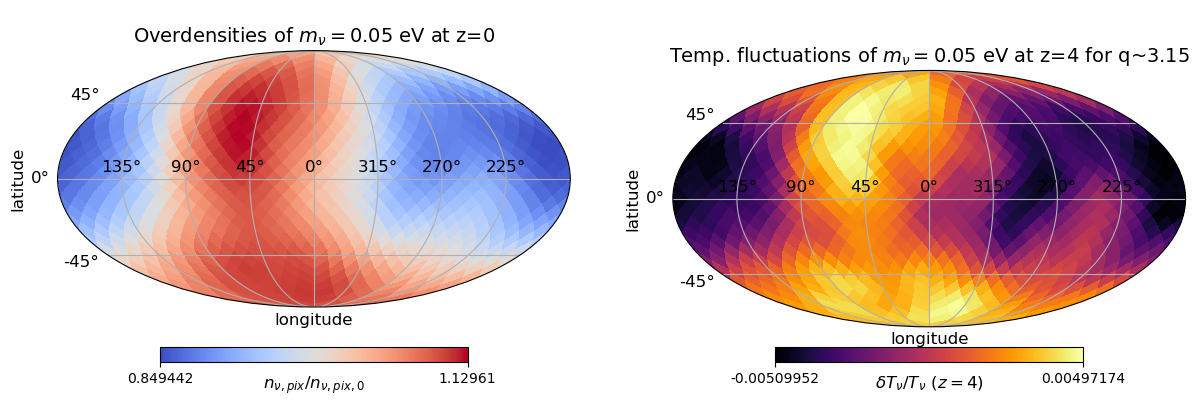

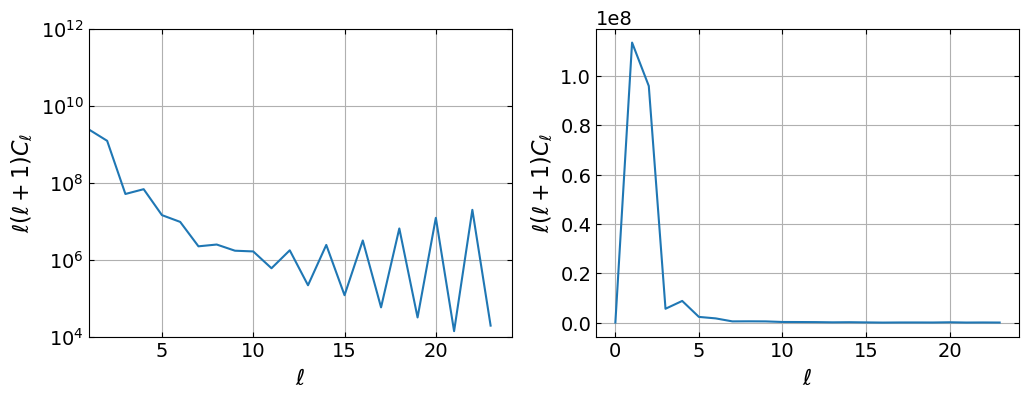

In [14]:
def primordial_fluctuations_no_halo(z, y_arr, m_idx, args):

    # Temp. perturbation matrix
    Delta_matrix = jnp.array([jnp.load(f"Data/Delta_arr_Nside{args.Nside}_Cl_q{qi}_z{z}.npy") for qi in range(50)])
    Delta_matrix *= args.uK/(Params.T_CNB * (1+z))
    # (50, 768)

    ic(Delta_matrix[Primordial.Cl_qi,:].min())
    ic(Delta_matrix[Primordial.Cl_qi,:].max())

    # Momenta at z=0 and z=4
    q_arr_z0 = y_arr[m_idx,:,0]
    q_arr_z4 = y_arr[m_idx,:,-1] / (1+z)  #? y_arr in terms of T_CNB(z=0) or T_CNB(z=4) ?

    # Find indices to match neutrino momenta to Cl momenta
    q_indices = jnp.abs(args.Cl_qs[None, :] - q_arr_z4[:, None]).argmin(axis=-1)

    # Select corresponding pixels, i.e. temp. perturbations, for all neutrinos
    nu_Deltas = Delta_matrix[q_indices, pix_indices]

    with open(f"{sim_folder}/sim_parameters.yaml", "r") as file:
        sim_setup = yaml.safe_load(file)
    allsky_Npix = sim_setup["Npix"]
    allsky_pnum = sim_setup["momentum_num"]

    q_blocks_z0 = q_arr_z0.reshape(allsky_Npix, allsky_pnum)
    q_blocks_z4 = q_arr_z4.reshape(allsky_Npix, allsky_pnum)

    # With following checks it's confirmed, that shape=(Npix, momentum_num) is correct
    # check_unit = Params.km/Params.s
    # print(jnp.allclose(z0_p_blocks[0,:]/check_unit, z0_p_blocks[1,:]/check_unit))    # True
    # print(jnp.allclose(z0_p_blocks[:,0]/check_unit, z0_p_blocks[:,1]/check_unit))    # False

    nu_Delta_blocks = nu_Deltas.reshape(allsky_Npix, allsky_pnum)

    # Left skymap (overdensities)
    pix_sr = 4*Params.Pi/allsky_Npix
    p_blocks_z0 = q_blocks_z0 * (Params.T_CNB)
    p_blocks_z4 = q_blocks_z4 * (Params.T_CNB * (1+z))
    n_cm3_all_sky = Physics.number_density_Delta(p_blocks_z0, p_blocks_z4, nu_Delta_blocks, pix_sr, Params())
    map_left = n_cm3_all_sky / (Params.N0/Primordial.Npix/(1/Params.cm**3))
    ic(jnp.sum(map_left))

    # Right skymap (primordial temp. perturbations)    
    map_right = Delta_matrix[args.Cl_qi,:]

    dict_left = dict(
        title=r'Overdensities of $m_\nu=0.05$ eV at z=0', 
        unit=r'$n_{\nu, pix} / n_{\nu, pix, 0}$',
        cmap='coolwarm',
        override_plot_properties={"cbar_pad": 0.1},
        sub=121)

    dict_right = dict(
        title=fr'Temp. fluctuations of $m_\nu=0.05$ eV at z={z} for q~3.15', 
        unit=r'$\delta T_\nu / T_\nu \,\, (z=4)$',
        cmap='inferno',
        sub=122)

    healpix_side_by_side(
        map_left, map_right, dict_left, dict_right, Params)
    

    #####################
    ### Power spectra ###
    #####################

    # note: healpy needs numpy arrays apparently, jax arrays give errors

    # Unit to compare to similar figures in literature.
    micro_Kelvin_unit = 1e12

    # Convert maps of neutrino densities to temperatures.
    temperature_map = jnp.cbrt((map_left*2*Params.Pi**2)/(3*zeta(3)))

    # Compute power spectrum of temperature all-sky map.
    cl = hp.sphtfunc.anafast(np.array(temperature_map))
    ell = jnp.arange(len(cl))
    power_spectrum = ell*(ell+1)*cl/(2*Params.Pi)*micro_Kelvin_unit

    # Compute cross-correlation spectrum of n_nu and DM maps.
    cross = hp.sphtfunc.anafast(np.array(temperature_map), np.array(map_right))
    cross_power_spectrum = ell*(ell+1)*cross/(2*Params.Pi)*micro_Kelvin_unit

    fig = plt.figure(figsize =(12, 4))
    fig.tight_layout()

    ax1 = fig.add_subplot(121)
    ell = jnp.arange(len(cl))
    ax1.semilogy(ell, power_spectrum)
    ax1.set_xlabel(r"$\ell$")
    ax1.set_xlim(1,)
    ax1.set_ylim(1e4,1e12)
    ax1.set_ylabel(r"$\ell(\ell+1)C_{\ell}$")
    ax1.grid()

    ax2 = fig.add_subplot(122)
    ell = jnp.arange(len(cross))
    ax2.plot(ell, cross_power_spectrum)
    ax2.set_xlabel(r"$\ell$")
    ax2.set_ylabel(r"$\ell(\ell+1)C_{\ell}$")
    ax2.grid()

    plt.show(); plt.close()
    



idx, val = find_closest_m_nu(sim_folder, 0.05)
ic(idx, val)


primordial_fluctuations_no_halo(
    z=4, 
    y_arr=y_arr, 
    m_idx=idx, 
    args=Primordial)